In [ ]:
import pandas as pd
from pymongo import MongoClient
from pymongo.errors import ConnectionFailure, OperationFailure

def insert_data_to_mongodb(data, db_name, collection_name):
    try:

        client = MongoClient('localhost', 27017)
        print("Connected to MongoDB successfully!")
        
        
        db = client[db_name]
        collection = db[collection_name]
        
        
        collection.insert_many(data.to_dict('records'))
        print("Data inserted successfully!")
    except ConnectionFailure:
        print("Failed to connect to MongoDB, check your server!")
    except OperationFailure as e:
        print("MongoDB operation failed:", e)
    finally:
        
        client.close()

def fetch_data_from_mongodb(db_name, collection_name):
    try:
        
        client = MongoClient('localhost', 27017)
        print("Connected to MongoDB successfully!")
        
        
        db = client[db_name]
        collection = db[collection_name]
        
        
        data = list(collection.find())
        return pd.DataFrame(data)
    except ConnectionFailure:
        print("Failed to connect to MongoDB, check your server!")
        return None
    except OperationFailure as e:
        print("MongoDB operation failed:", e)
        return None
    finally:
        
        client.close()


data = pd.read_csv('reduced_dataset.csv')


insert_data_to_mongodb(data, 'pregnancy', 'responses')


fetched_data = fetch_data_from_mongodb('pregnancy', 'responses')
if fetched_data is not None:
    print("Data fetched successfully!")


## Predicting the risk level of pregnancy complications


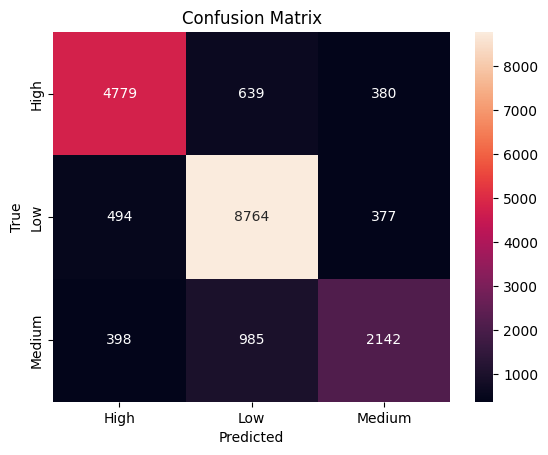

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

data = fetched_data

data.dropna(subset=['Data_Value'], inplace=True)

data['Risk_Level'] = pd.cut(data['Data_Value'], bins=[0, 33, 66, 100], labels=['Low', 'Medium', 'High'])

features = ['LocationDesc', 'Break_Out_Category', 'Sample_Size', 'Question']
X = data[features]
y = data['Risk_Level']

imputer_X = SimpleImputer(strategy='most_frequent')
X = pd.DataFrame(imputer_X.fit_transform(X), columns=features)

imputer_y = SimpleImputer(strategy='most_frequent')
y = pd.Series(imputer_y.fit_transform(y.values.reshape(-1, 1)).ravel())

X = pd.get_dummies(X, columns=['LocationDesc', 'Break_Out_Category', 'Question'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Classification Report:
Precision: Indicates the accuracy of positive predictions. For example, the precision for "High" risk level is 0.84, meaning that 84% of the predictions made as "High" are correct.
Recall (Sensitivity): Measures the ability of the model to find all the relevant cases within a class. For "High" risk, the recall is 0.82, indicating that the model correctly identifies 82% of all actual "High" risk cases.
F1-Score: The weighted average of Precision and Recall. This score takes both false positives and false negatives into account. An F1-score is a better measure of the incorrectly classified cases than the Accuracy. For "High" risk, it's 0.83.
Support: The number of actual occurrences of the class in the dataset. For "High" risk, there are 5798 instances.

Confusion Matrix:
This matrix shows the actual class labels vs. the predicted class labels in a grid format. It helps identify how well the model is performing with respect to each class.
For example, the model predicted 4779 instances correctly as "High" risk (True Positive for High). However, it incorrectly predicted 639 actual "High" cases as "Low" and 380 as "Medium" (False Negatives for High).
Similarly, for "Low" risk predictions, it correctly predicted 8764 cases, but 494 "Low" risk cases were predicted as "High" and 377 as "Medium".
The off-diagonal numbers represent classification errors (mistakes by the model), with rows indicating the actual classes and columns indicating the predicted classes.

## Classify whether prenatal care in different regions is Adequate, Inadequate, or Intermediate

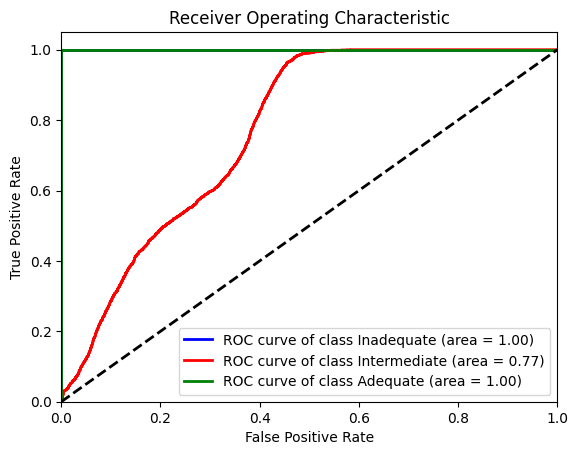

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize

data = fetched_data

data['Care_Adequacy'] = pd.cut(data['Data_Value'], bins=[0, 50, 75, 100], labels=['Inadequate', 'Intermediate', 'Adequate'])
data.dropna(subset=['Care_Adequacy'], inplace=True)  

features = ['LocationDesc', 'Data_Value', 'Low_Confidence_Limit', 'High_Confidence_Limit']
X = data[features].copy()
y = data['Care_Adequacy']

encoder = LabelEncoder()
X.loc[:, 'LocationDesc'] = encoder.fit_transform(X['LocationDesc'])

numeric_features = ['Data_Value', 'Low_Confidence_Limit', 'High_Confidence_Limit']
imputer = SimpleImputer(strategy='median')
X.loc[:, numeric_features] = imputer.fit_transform(X[numeric_features])

y = label_binarize(y, classes=['Inadequate', 'Intermediate', 'Adequate'])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
classifier.fit(X_train, y_train)

y_score = classifier.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(['Inadequate', 'Intermediate', 'Adequate'][i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

ROC Curve Interpretation:
The ROC curve plots the True Positive Rate (TPR, or sensitivity) against the False Positive Rate (FPR, or 1-specificity) at various threshold settings. The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
The diagonal dashed line represents a random classifier (an AUC of 0.5), where the classifier's ability to discriminate between classes is no better than chance.

AUC (Area Under the Curve):
The AUC for each class gives a single measure of how well the classifier is able to distinguish between positive (adequate) and negative (inadequate or intermediate) classes for that particular category.
Class Inadequate: An AUC of 1.00 suggests perfect classification with no misclassifications.
Class Intermediate: An AUC of 0.77 indicates moderate classification ability, with some overlap between Intermediate and other classes.
Class Adequate: An AUC of 1.00 again suggests perfect classification.

Class-Specific Performance:
High Performance for 'Adequate' and 'Inadequate': The model perfectly distinguishes both 'Adequate' and 'Inadequate' prenatal care from other classes, as indicated by the AUC of 1.00 for both. This means the model has 100% sensitivity and specificity for these categories at certain thresholds.
Lower Performance for 'Intermediate': The AUC of 0.77 for 'Intermediate' care shows that the model has more difficulty distinguishing between intermediate levels of care and other categories, leading to more false positives or false negatives in this category.

Practical Implications:
The results suggest that the model is highly reliable for identifying clear cases of adequate and inadequate prenatal care but may require further adjustment or additional features to better classify intermediate cases.
This visualization helps in understanding the model's effectiveness in different scenarios and can guide further refinement of the model or operational thresholds.

## Predict Response Levels to Health Policy Changes: Utilizing data points like 'Year', 'LocationDesc', 'Break_Out' (specific groups), and 'Data_Value' changes over time, you can predict how different groups might respond to new health policies or changes. The classification could be Positive, Neutral, or Negative response, helping policymakers understand the impact of their decisions across different demographics.


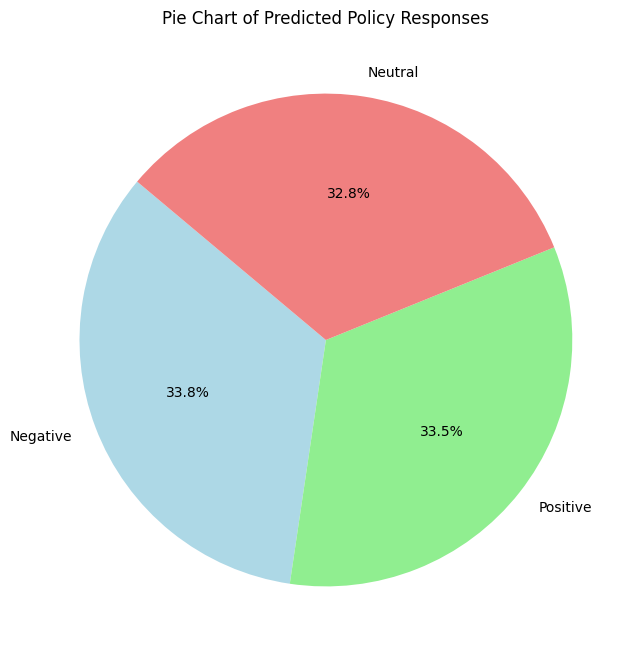

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

data = fetched_data

data['Policy_Response'] = pd.qcut(data['Data_Value'], q=3, labels=['Negative', 'Neutral', 'Positive'])
data.dropna(subset=['Policy_Response'], inplace=True)  

features = ['Year', 'LocationDesc', 'Sample_Size', 'Data_Value']
X = data[features].copy() 
y = data['Policy_Response']

imputer = SimpleImputer(strategy='median')
X.loc[:, 'Data_Value'] = imputer.fit_transform(X[['Data_Value']]) 
X.loc[:, 'Sample_Size'] = imputer.fit_transform(X[['Sample_Size']])

encoder = LabelEncoder()
X.loc[:, 'LocationDesc'] = encoder.fit_transform(X['LocationDesc'])  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

predicted_df = pd.DataFrame({'Predicted_Response': y_pred})

response_counts = predicted_df['Predicted_Response'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(response_counts, labels=response_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Pie Chart of Predicted Policy Responses')
plt.show()


The output pie chart provides a visual representation of the predicted response levels to health policy changes across different groups, represented by the proportion of each response category (Positive, Negative, Neutral). This visualization aids policymakers by showing:

1. **Proportional Distribution of Responses:** The pie chart clearly demonstrates the percentage of data points (or individuals/groups within the study) predicted to have a Positive, Negative, or Neutral response to health policy changes. This helps in understanding the proportional sentiment towards the policy across the dataset.

2. **Immediate Visual Impact:** The pie chart's segments allow policymakers to immediately see which responses are most common, as each segment's size visually represents its proportion. For example, if the Negative segment is notably larger, it may suggest dissatisfaction with the policy.

3. **Quantitative Insights for Decision-Making:** This plot acts as a tool to support decision-making by providing a clear, quantitative view of public reaction. It can guide further qualitative analysis to explore why certain responses are prevalent and how policies might be optimized.

4. **Simplicity and Accessibility:** The pie chart format is straightforward and easily interpretable by a wide audience, making it suitable for presentations or reports where quick understanding is necessary.

5. **Balanced View:** Given the near equal distribution among the three response categories in the pie chart, policymakers can infer that there is a balanced view towards the policy changes, which might indicate areas of both support and opposition that could be further explored.

In summary, the pie chart answers the question by quantifying and visualizing the predicted responses in a proportional format, allowing for an intuitive understanding of how different groups might perceive new health policies. This visualization serves as a foundational tool for policymakers to gauge the impact of their decisions and strategize accordingly.